In [6]:
!pip install matplotlib

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import random_split,DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np




In [13]:
path="augumented"

In [14]:
torch.cuda.empty_cache()

In [15]:
transformation=transforms.Compose([
    transforms.Resize((128, 128)),  # Resize image to 224x224
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize if needed
])

In [16]:
dataset=ImageFolder(path,transform=transformation)
len(dataset)

786

In [17]:
print(dataset[0][0].shape)
print(dataset[0][0][0][0])

torch.Size([3, 128, 128])
tensor([-0.9922, -0.9922, -0.9922, -0.9922, -0.9922, -0.9843, -0.9843, -0.9922,
        -0.9843, -0.9843, -0.9922, -0.9922, -0.9843, -0.9922, -0.9843, -0.9843,
        -0.9922, -0.9843, -0.9843, -0.9922, -0.9922, -0.9843, -0.9843, -0.9843,
        -0.9843, -0.9843, -0.9843, -0.9843, -0.9843, -0.9843, -0.9765, -0.9765,
        -0.9765, -0.9765, -0.9765, -0.9686, -0.9765, -0.9765, -0.9765, -0.9686,
        -0.9765, -0.9686, -0.9608, -0.8196, -0.3647, -0.1059, -0.0980, -0.0667,
        -0.0275, -0.0039,  0.0118,  0.0431,  0.0745,  0.0902,  0.1059,  0.2157,
         0.3098,  0.3020,  0.2706,  0.1922,  0.1765,  0.1922,  0.2157,  0.2706,
         0.2706,  0.2549,  0.2392,  0.2392,  0.2235,  0.2078,  0.2235,  0.2471,
         0.2392,  0.2157,  0.2314,  0.2235,  0.1922,  0.2000,  0.1529,  0.1373,
         0.1216,  0.0824,  0.0510,  0.0510, -0.2157, -0.7569, -0.9608, -0.9686,
        -0.9686, -0.9686, -0.9765, -0.9765, -0.9765, -0.9765, -0.9765, -0.9686,
        -0.976

In [18]:
dataset.classes

['Normal', 'RP']

In [19]:
#create train  validation set
total_size = len(dataset)


# Perform the split
train_ds, val_ds = random_split(dataset, [600, 186], generator=torch.Generator().manual_seed(42))


In [20]:
len(train_ds)

600

In [21]:
#creating batches
batch=32
train_dl=DataLoader(train_ds,batch_size=batch,shuffle=True,num_workers=2,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size=2*batch,num_workers=2,pin_memory=True)

In [22]:
from torchvision.utils import make_grid
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)
def denormalize(images,means,stds):
    means=torch.tensor(means).reshape(1,3,1,1)
    stds=torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means
def show_batch(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(12,12))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images=denormalize(images,*stats)
        ax.imshow(make_grid(denorm_images[:64],nrow=8).permute(1,2,0).clamp(0,1))
        break


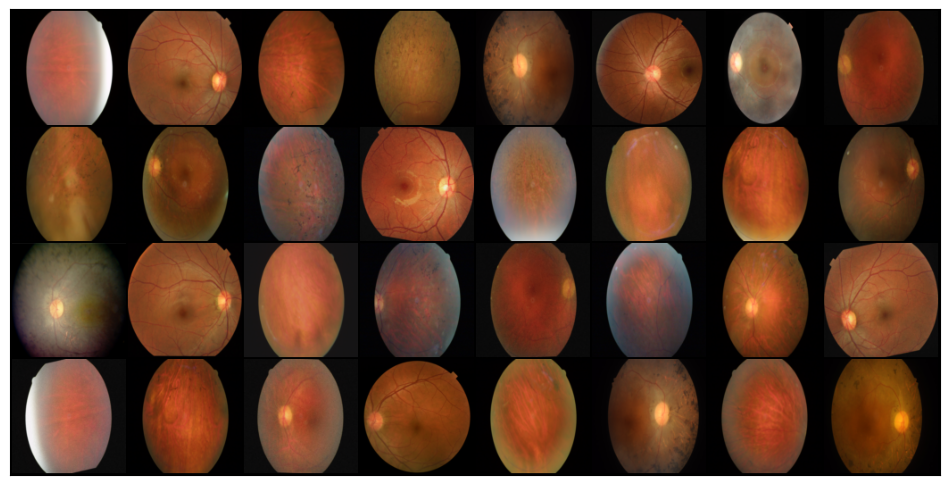

In [23]:
show_batch(train_dl)

## Defining the Model

In [24]:
#image classification base
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels=batch
        outputs=self(images)
        loss=F.cross_entropy(outputs,labels)
        return loss
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    def validation_epoch_end(self,outputs):
        acc=[x["val_acc"] for x in outputs]
        loss=[x['val_loss'] for x in outputs]

        mean_acc=torch.stack(acc).mean()
        mean_loss=torch.stack(loss).mean()
        return {"val_loss":mean_loss.item(),"val_acc":mean_acc.item()}
    def epoch_end(self,epoch,result):
        print("Epoch [{}], train_loss:{:.4f} val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"],result['val_loss'], result['val_acc']))


def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [25]:
# def conv_block(in_channels,out_channels,pool=False):
#     layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=1),
#            nn.BatchNorm2d(out_channels),
#            nn.ReLU(inplace=True)]
#     if pool:layers.append(nn.MaxPool2d(2))
#     return nn.Sequential(*layers)

In [27]:
from torchvision import models
class Resnet_Model(ImageClassificationBase):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        #3X32X32
        self.network=models.resnet50(pretrained=False)
        self.network.fc=nn.Linear(self.network.fc.in_features,num_classes)
    def forward(self,xb):
        return self.network(xb)


In [28]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [29]:
device=get_default_device()
device

device(type='cpu')

In [30]:
def to_device(data,device):
    if(isinstance(data,(list,tuple))):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [32]:
model=to_device(Resnet_Model(3,2),device)
model

/home/commander/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/commander/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Resnet_Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [33]:
class Device_Data_Loader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for x in self.dl:
            yield to_device(x,device)
    def __len__(self):
        return len(self.dl)


In [34]:
train_dl=Device_Data_Loader(train_dl,device)
val_dl=Device_Data_Loader(val_dl,device)

## Training

In [35]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()  # (for no randamization)some layer behave diff for train and test for ex :batchnorm,dropout we dont require dropout while evaulating
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [36]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [37]:
def fit_one_cycle(epochs,max_lr,model,train_dl,val_dl,weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history=[]
    optimizer=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_dl))

    for epoch in range(epochs):
        #training phase
        model.train()
        train_losses=[]
        lrs=[]
        for batch in train_dl:
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # grad clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            #record $update lr
            lrs.append(get_lr(optimizer))
            sched.step() #lr differ for each batch
        #validation phase
        result=evaluate(model,val_dl)
        result["train_loss"]=torch.stack(train_losses).mean().item()
        result["lrs"]=lrs
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [38]:
def fit(epochs,lr,model,train_dl,val_dl,weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
  opt_func=opt_func(model.parameters(),lr=lr,weight_decay=weight_decay)
  history=[]
  for epoch in range(epochs):
      train_losses=[]
      for batch in train_dl:
          loss=model.training_step(batch)
          loss.backward()
           # grad clipping
          if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
          opt_func.step()
          opt_func.zero_grad()
          train_losses.append(loss)
      result=evaluate(model,val_dl)
      result["train_loss"]=torch.stack(train_losses).mean().item()
      model.epoch_end(epoch,result)
      history.append(result)
  return history

In [39]:
hist=[evaluate(model,val_dl)]
print(hist)

[{'val_loss': 0.7133085131645203, 'val_acc': 0.4159482717514038}]


In [40]:
epochs=60
max_lr=0.01
grad_clip=0.1
weight_decay=1e-4
opt_func=torch.optim.Adam

In [41]:
%%time
history=fit_one_cycle(epochs,max_lr,model,train_dl,val_dl,grad_clip=grad_clip,weight_decay=weight_decay,opt_func=opt_func)

Epoch [0], train_loss:0.8187 val_loss: 2.2732, val_acc: 0.5422
Epoch [1], train_loss:0.4529 val_loss: 0.6826, val_acc: 0.5625
Epoch [2], train_loss:0.3659 val_loss: 1.0714, val_acc: 0.7597
Epoch [3], train_loss:0.4288 val_loss: 3.3592, val_acc: 0.3951
Epoch [4], train_loss:0.4366 val_loss: 1.0701, val_acc: 0.7337
Epoch [5], train_loss:0.4457 val_loss: 0.8562, val_acc: 0.5329
Epoch [6], train_loss:0.3307 val_loss: 0.3859, val_acc: 0.8400
Epoch [7], train_loss:0.3016 val_loss: 0.3213, val_acc: 0.8707
Epoch [8], train_loss:0.3003 val_loss: 0.6857, val_acc: 0.8035
Epoch [9], train_loss:0.3540 val_loss: 0.6959, val_acc: 0.6564
Epoch [10], train_loss:0.7298 val_loss: 347.9531, val_acc: 0.4526
Epoch [11], train_loss:0.4264 val_loss: 3.9894, val_acc: 0.5375
Epoch [12], train_loss:0.3988 val_loss: 3.8877, val_acc: 0.6049
Epoch [13], train_loss:0.4494 val_loss: 0.5395, val_acc: 0.7460
Epoch [14], train_loss:0.3316 val_loss: 0.3932, val_acc: 0.8060
Epoch [15], train_loss:0.2704 val_loss: 0.2224, 

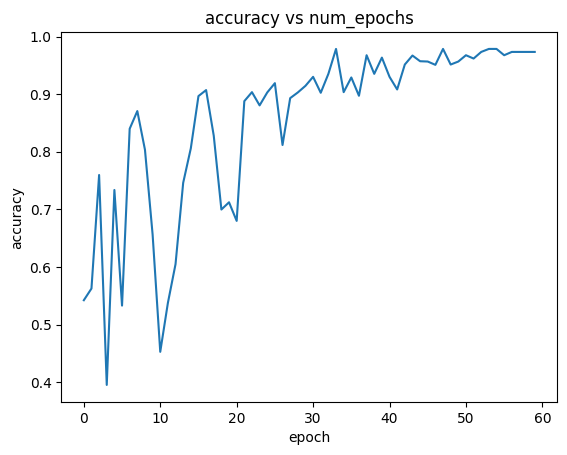

In [42]:
def plot_Accuracies(history):
    plt.plot([x["val_acc"] for x in history])
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("accuracy vs num_epochs")


plot_Accuracies(history)

In [43]:
def plot_losses(history):
    train_losses=[x["train_loss"] for x in history]
    val_losses=[x["val_loss"] for x in history]
    plt.plot(train_losses,"-bx")
    plt.plot(val_losses,"-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training","Validation"])
    plt.title("loss vs No of epochs")

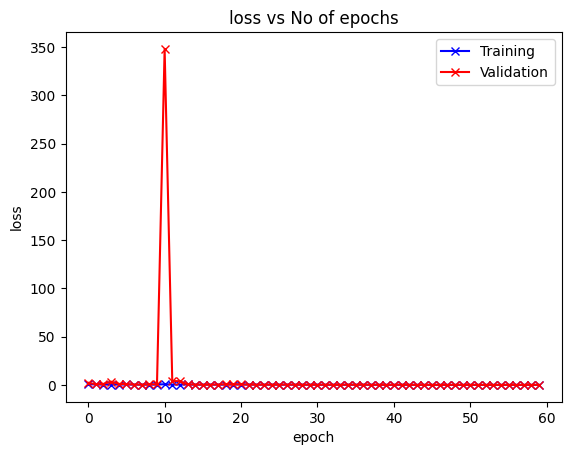

In [44]:
plot_losses(history)

4e-08


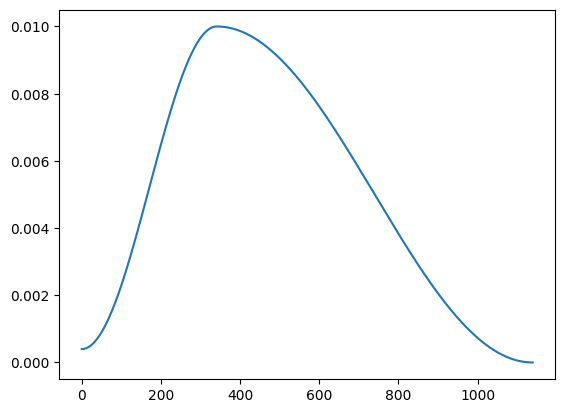

In [45]:
lrs=[]
for i in history:
  lrs.extend(i["lrs"])
plt.plot(lrs)
print(lrs[-1])

## Evaluation

In [46]:

evaluate(model,val_dl)

{'val_loss': 0.0702614113688469, 'val_acc': 0.9734194874763489}

In [47]:
torch.save(model.state_dict(),"rgukt_pro.pth")